In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import joblib
from torchsummary import summary
import pytorch_ssim
import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial settings

In [3]:
t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1713264138.7723837


## Load building data

In [4]:
data_new_generated = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/fortran_building_volume_frac_codes/building_data/building_images_550_256_256.npy")
print(data_new_generated.shape)

concatenated_data_revalued = data_new_generated

(550, 256, 256)


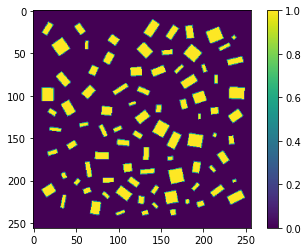

In [6]:
# plt.imshow(concatenated_data_revalued[201,:,:])
plt.imshow(concatenated_data_revalued[10,:,:])
plt.colorbar()

In [8]:
concatenated_data_256 = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/InterpolatedResult256/FpB_Interpolated_t0_VelocityAbsorption_256_256.npy")
print(concatenated_data_256.shape)

(2, 256, 256)


In [9]:
concatenated_data_256_revalued = concatenated_data_256.copy()
concatenated_data_256_revalued[concatenated_data_256 > 1500] = 1
concatenated_data_256_revalued[concatenated_data_256 <= 1500] = 0

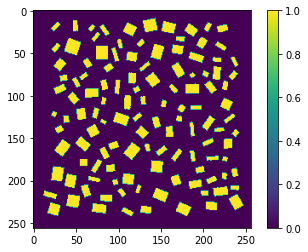

In [11]:
# plt.imshow(concatenated_data_revalued[201,:,:])
plt.imshow(concatenated_data_256_revalued[0,:,:])
plt.colorbar()

In [98]:
concatenated_data_revalued = concatenated_data_revalued[:,:,:].reshape(-1,256,256)
print(concatenated_data_revalued.shape)

(550, 256, 256)


In [99]:
# Original image
# original_image = concatenated_data_revalued

# # Rotate the image 90 degrees three times to create three new images
# rotated_image1 = np.rot90(original_image, 1, axes=(1, 2))  # 90 degrees rotation
# rotated_image2 = np.rot90(original_image, 2, axes=(1, 2))  # 180 degrees rotation
# rotated_image3 = np.rot90(original_image, 3, axes=(1, 2))  # 270 degrees rotation

# # Stack the original image and the rotated images along the 0th dimension
# all_images = np.stack((original_image, rotated_image1, rotated_image2, rotated_image3), axis=0)

all_images = concatenated_data_revalued.reshape(-1,1,256,256)

print(all_images.shape)  # Should print (4, 1, 256, 256)

(550, 1, 256, 256)


In [76]:
# Original image
original_image_384 = concatenated_data_revalued_384

# Rotate the image 90 degrees three times to create three new images
rotated_image1_384 = np.rot90(original_image_384, 1, axes=(1, 2))  # 90 degrees rotation
rotated_image2_384 = np.rot90(original_image_384, 2, axes=(1, 2))  # 180 degrees rotation
rotated_image3_384 = np.rot90(original_image_384, 3, axes=(1, 2))  # 270 degrees rotation

# Stack the original image and the rotated images along the 0th dimension
all_images_384 = np.stack((original_image_384, rotated_image1_384, rotated_image2_384, rotated_image3_384), axis=0)

print(all_images_384.shape)  # Should print (4, 1, 384, 384)

(4, 1, 384, 384)


## Create data loader

In [129]:
batch_size = 32

# dataloader = DataLoader(concatenated_data_revalued)
dataloader1 = DataLoader(all_images, batch_size=batch_size, shuffle = True)

dataloader2 = DataLoader(all_images_384, batch_size=batch_size)

val_dataloader = dataloader2

In [130]:
print(len(dataloader1))

18


## Define the model

### latent_channel_number = 1

In [9]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 1


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 1, 64, 64]              65
         LeakyReLU-8            [-1, 1, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]              80
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### latent_channel_number = 2

In [18]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 2, 64, 64]             130
         LeakyReLU-8            [-1, 2, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]             144
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### latent_channel_number = 2 latent size 32

In [90]:
# fist_hidden_layer = 16*4*2
# second_hidden_layer = 32*4*2
# latent_channel_number = 2


# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(fist_hidden_layer, 64, kernel_size=2, stride=1, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(32, 2, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#         )

#         # Decoder layers
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(2, 32, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(64, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [91]:
fist_hidden_layer = 16*4*2
second_hidden_layer = 32*4*2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer*2, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer*2, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, 64, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(64, 1, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(64, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

        # Trainable threshold
        self.threshold = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid((x - self.threshold) * 10)  # Differentiable approximation of step function
        return x

In [92]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 128, 128]           1,280
         LeakyReLU-2        [-1, 256, 128, 128]               0
            Conv2d-3          [-1, 256, 64, 64]         262,400
         LeakyReLU-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 128, 65, 65]         131,200
         LeakyReLU-6          [-1, 128, 65, 65]               0
            Conv2d-7           [-1, 64, 64, 64]          32,832
         LeakyReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9            [-1, 1, 32, 32]             257
        LeakyReLU-10            [-1, 1, 32, 32]               0
  ConvTranspose2d-11           [-1, 64, 64, 64]             320
        LeakyReLU-12           [-1, 64, 64, 64]               0
  ConvTranspose2d-13          [-1, 128, 65, 65]          32,896
        LeakyReLU-14          [-1, 128,

In [93]:
# Let's say the code you want to convert to a string is in cell 1
model_code = In[-3]
# Now, model_code contains the code from cell 1 as a string
print(model_code)

fist_hidden_layer = 16*4*2
second_hidden_layer = 32*4*2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer*2, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer*2, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, 64, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(64, 1, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
         

### Containing kernel size 3

In [79]:
# Define the autoencoder model
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
hid4 = 80*2
hid5 = 40*2
hid6 = 20*2
            
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=1, padding=1),#1 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=2, stride=2),#2 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=1, padding=1),#3 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, hid4, kernel_size=2, stride=2),#4 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid4, hid5, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid5, hid6, kernel_size=2, stride=2),#6 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid6, 1, kernel_size=3, stride=1, padding=1),#7 - Smoothing the change in number of channels; no reduction in output size
            #We should finish with the same number of channels of the input (4)
            # nn.LeakyReLU(negative_slope=0.2)
            nn.Tanh()
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, hid6, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid6, hid5, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid5, hid4, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid4, hid3, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid3, hid2, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid2, hid1, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid1, 1, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            # nn.Identity()
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [80]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1, 256, 256))
summary(autoencoder, (1, 384, 384))
summary(autoencoder, (1, 384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 256, 256]             400
         LeakyReLU-2         [-1, 40, 256, 256]               0
            Conv2d-3         [-1, 80, 128, 128]          12,880
         LeakyReLU-4         [-1, 80, 128, 128]               0
            Conv2d-5        [-1, 160, 128, 128]         115,360
         LeakyReLU-6        [-1, 160, 128, 128]               0
            Conv2d-7          [-1, 160, 64, 64]         102,560
         LeakyReLU-8          [-1, 160, 64, 64]               0
            Conv2d-9           [-1, 80, 64, 64]         115,280
        LeakyReLU-10           [-1, 80, 64, 64]               0
           Conv2d-11           [-1, 40, 32, 32]          12,840
        LeakyReLU-12           [-1, 40, 32, 32]               0
           Conv2d-13            [-1, 1, 32, 32]             361
             Tanh-14            [-1, 1,

In [45]:
# Define the autoencoder model
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
latent = 1

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, latent, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent, hid3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid3, hid2, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid2, hid1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid1, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        print(x.shape)
        return x

In [46]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1, 256, 256))
summary(autoencoder, (1, 384, 384))
summary(autoencoder, (1, 384*2, 384*2))

torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]             400
         LeakyReLU-2         [-1, 40, 128, 128]               0
            Conv2d-3           [-1, 80, 64, 64]          28,880
         LeakyReLU-4           [-1, 80, 64, 64]               0
            Conv2d-5          [-1, 160, 32, 32]         115,360
         LeakyReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7            [-1, 1, 32, 32]           1,441
         LeakyReLU-8            [-1, 1, 32, 32]               0
   ConvTranspose2d-9          [-1, 160, 64, 64]           1,600
        LeakyReLU-10          [-1, 160, 64, 64]               0
  ConvTranspose2d-11         [-1, 80, 128, 128]         115,280
        LeakyReLU-12         [-1, 80, 128, 128]               0
  ConvTranspose2d-

In [81]:
# Let's say the code you want to convert to a string is in cell 1
model_code = In[-3]
# Now, model_code contains the code from cell 1 as a string
print(model_code)

# Define the autoencoder model
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
hid4 = 80*2
hid5 = 40*2
hid6 = 20*2
            
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=1, padding=1),#1 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=2, stride=2),#2 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=1, padding=1),#3 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, hid4, kernel_size=2, stride=2),#4 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid4, hid5, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change 

### Containing kernel size 1

In [138]:
fist_hidden_layer = 16*4*2
second_hidden_layer = 32*4*2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer*2, kernel_size=2, stride=2, padding=0),  
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer*2, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.ReLU(),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=1, stride=1, padding=0),  
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer, 64, kernel_size=1, stride=1, padding=0),  
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=2, stride=2, padding=0),  
            nn.Tanh()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=2, stride=2, padding=0),  
            nn.ReLU(),
            nn.ReLU(),
            nn.ConvTranspose2d(64, fist_hidden_layer, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.ReLU(),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [69]:
# # Define the autoencoder model
# # encoder kernel size = 1, decoder kernel size = 5
# hid1 = 20*2
# hid2= 40*2
# hid3 = 80*2
# hid4 = 80*2
# hid5 = 40*2
# hid6 = 20*2
            
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
 
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, hid1, kernel_size=1, stride=1, padding=0),#1 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid1, hid2, kernel_size=2, stride=2),#2 - reduction by 2
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid2, hid3, kernel_size=1, stride=1, padding=0),#3 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid3, hid4, kernel_size=2, stride=2),#4 - reduction by 2
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid4, hid5, kernel_size=1, stride=1, padding=0),#5 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid5, hid6, kernel_size=2, stride=2),#6 - reduction by 2
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.Conv2d(hid6, 1, kernel_size=1, stride=1, padding=0),#7 - Smoothing the change in number of channels; no reduction in output size
#             #We should finish with the same number of channels of the input (4)
#             # nn.LeakyReLU(negative_slope=0.05)
#             nn.Tanh()
#         )
 
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(1, hid6, kernel_size=5, stride=1, padding=2),# Smoothing the change in number of channels; no increase in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid6, hid5, kernel_size=2, stride=2),
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid5, hid4, kernel_size=5, stride=1, padding=2),# Smoothing the change in number of channels; no increase in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid4, hid3, kernel_size=2, stride=2),
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid3, hid2, kernel_size=5, stride=1, padding=2),# Smoothing the change in number of channels; no increase in output size
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid2, hid1, kernel_size=2, stride=2),
#             nn.LeakyReLU(negative_slope=0.05),
#             nn.ConvTranspose2d(hid1, 1, kernel_size=5, stride=1, padding=2),# Smoothing the change in number of channels; no increase in output size
#             # nn.Identity()
#             nn.Sigmoid()
#         )
 
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [108]:
# Define the autoencoder model
# encoder kernel size = 1, decoder kernel size = 3
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
hid4 = 80*2
hid5 = 40*2
hid6 = 20*2
            
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=1, stride=1, padding=0),#1 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=2, stride=2),#2 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=1, stride=1, padding=0),#3 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, hid4, kernel_size=2, stride=2),#4 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid4, hid5, kernel_size=1, stride=1, padding=0),#5 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid5, hid6, kernel_size=2, stride=2),#6 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid6, 1, kernel_size=1, stride=1, padding=0),#7 - Smoothing the change in number of channels; no reduction in output size
            #We should finish with the same number of channels of the input (4)
            # nn.LeakyReLU(negative_slope=0.2)
            nn.Tanh()
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, hid6, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid6, hid5, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid5, hid4, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid4, hid3, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid3, hid2, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid2, hid1, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid1, 1, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.Identity(),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [139]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1, 256, 256))
summary(autoencoder, (1, 384, 384))
summary(autoencoder, (1, 384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 128, 128]           1,280
              ReLU-2        [-1, 256, 128, 128]               0
            Conv2d-3          [-1, 256, 64, 64]         262,400
              ReLU-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          32,896
              ReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]           8,256
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9            [-1, 1, 32, 32]             257
             Tanh-10            [-1, 1, 32, 32]               0
  ConvTranspose2d-11           [-1, 64, 64, 64]             320
             ReLU-12           [-1, 64, 64, 64]               0
             ReLU-13           [-1, 64, 64, 64]               0
  ConvTranspose2d-14          [-1, 128,

In [140]:
# Let's say the code you want to convert to a string is in cell 1
model_code = In[-3]
# Now, model_code contains the code from cell 1 as a string
print(model_code)

fist_hidden_layer = 16*4*2
second_hidden_layer = 32*4*2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer*2, kernel_size=2, stride=2, padding=0),  
            # nn.LeakyReLU(negative_slope=0.05),
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer*2, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            # nn.LeakyReLU(negative_slope=0.05),
            nn.ReLU(),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=1, stride=1, padding=0),  
            # nn.LeakyReLU(negative_slope=0.05),
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer, 64, kernel_size=1, stride=1, padding=0),  
            # nn.LeakyReLU(negative_slope=0.05),
            nn.ReLU(),
            # nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change

## Train the model

In [141]:
# Specify the IDs of the GPUs you want to use
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

# Initialize a new run
wandb.init(project="compression - building field", name="same model as velocity for new data Tanh")

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)


criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction

lr = 0.001

optimizer1 = optim.Adam(autoencoder.parameters(), lr=lr)
optimizer2 = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 3000

# Early stopping parameters
patience = 20  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
epochs_no_improve = 0  # Counter to keep track of number of epochs without improvement

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Save the model code to a text file
with open("model_code.py", "w") as file:
    file.write(model_code)
# Create a new artifact
artifact = wandb.Artifact('model-code', type='code')
# Add the file to the artifact
artifact.add_file("model_code.py")
# Log the artifact
wandb.log_artifact(artifact)

# Training loop
for epoch in range(num_epochs):
    autoencoder.train()
    for data in dataloader1:
        inputs = data.to(device)  # Move data to GPU
        # print(inputs.shape)
        optimizer1.zero_grad()
        outputs = autoencoder(inputs)
        # print(outputs.shape)
        # print(inputs.shape)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer1.step()

    # for data in dataloader2:
    #     inputs = data.to(device)  # Move data to GPU
    #     # print(inputs.shape)
    #     optimizer2.zero_grad()
    #     outputs = autoencoder(inputs)
    #     # print(outputs.shape)
    #     # print(inputs.shape)
    #     loss = criterion(outputs, inputs)
    #     # loss = 1 - ssim_multichannel(outputs, inputs)
    #     loss.backward()
    #     optimizer2.step()

    # Validation
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        # for data in val_dataloader:
        for data in dataloader1:
            inputs = data.to(device)  # Move data to GPU
            # print(inputs.shape)
            outputs = autoencoder(inputs)
            val_loss += criterion(outputs, inputs).item()

    val_loss /= len(val_dataloader)  # Get average validation loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # If validation loss hasn't improved for 'patience' epochs, stop training
    if epochs_no_improve == patience:
        print('Early stopping!')
        break

    # Log the losses to wandb
    wandb.log({"loss": loss.item(), "Validation loss": val_loss})

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

Validation loss,██▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,██▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,0.32461
loss,0.0186


2024-04-15 19:05:37.715789: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch [1/3000], Loss: 0.1130, Validation Loss: 2.0496
Epoch [1/3000], Loss: 0.1130
Epoch [2/3000], Loss: 0.0999, Validation Loss: 1.8150
Epoch [2/3000], Loss: 0.0999
Epoch [3/3000], Loss: 0.0544, Validation Loss: 1.0177
Epoch [3/3000], Loss: 0.0544
Epoch [4/3000], Loss: 0.0382, Validation Loss: 0.7286
Epoch [4/3000], Loss: 0.0382
Epoch [5/3000], Loss: 0.0303, Validation Loss: 0.5384
Epoch [5/3000], Loss: 0.0303
Epoch [6/3000], Loss: 0.0279, Validation Loss: 0.4815
Epoch [6/3000], Loss: 0.0279
Epoch [7/3000], Loss: 0.0239, Validation Loss: 0.4546
Epoch [7/3000], Loss: 0.0239
Epoch [8/3000], Loss: 0.0228, Validation Loss: 0.4120
Epoch [8/3000], Loss: 0.0228
Epoch [9/3000], Loss: 0.0238, Validation Loss: 0.4018
Epoch [9/3000], Loss: 0.0238
Epoch [10/3000], Loss: 0.0231, Validation Loss: 0.3950
Epoch [10/3000], Loss: 0.0231
Epoch [11/3000], Loss: 0.0225, Validation Loss: 0.3874
Epoch [11/3000], Loss: 0.0225
Epoch [12/3000], Loss: 0.0199, Validation Loss: 0.3767
Epoch [12/3000], Loss: 0.019

KeyboardInterrupt: 

In [142]:
print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

Training time: 12608.635546922684


## Load saved model

In [14]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression - building field/model:v27', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-03-25 20:12:14.071010: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

### 6*6 domain

In [143]:
print(concatenated_data_revalued.shape)

(550, 256, 256)


(1, 256, 256)
latent space shape torch.Size([1, 1, 32, 32])
(1, 1, 256, 256)


<Figure size 432x288 with 0 Axes>

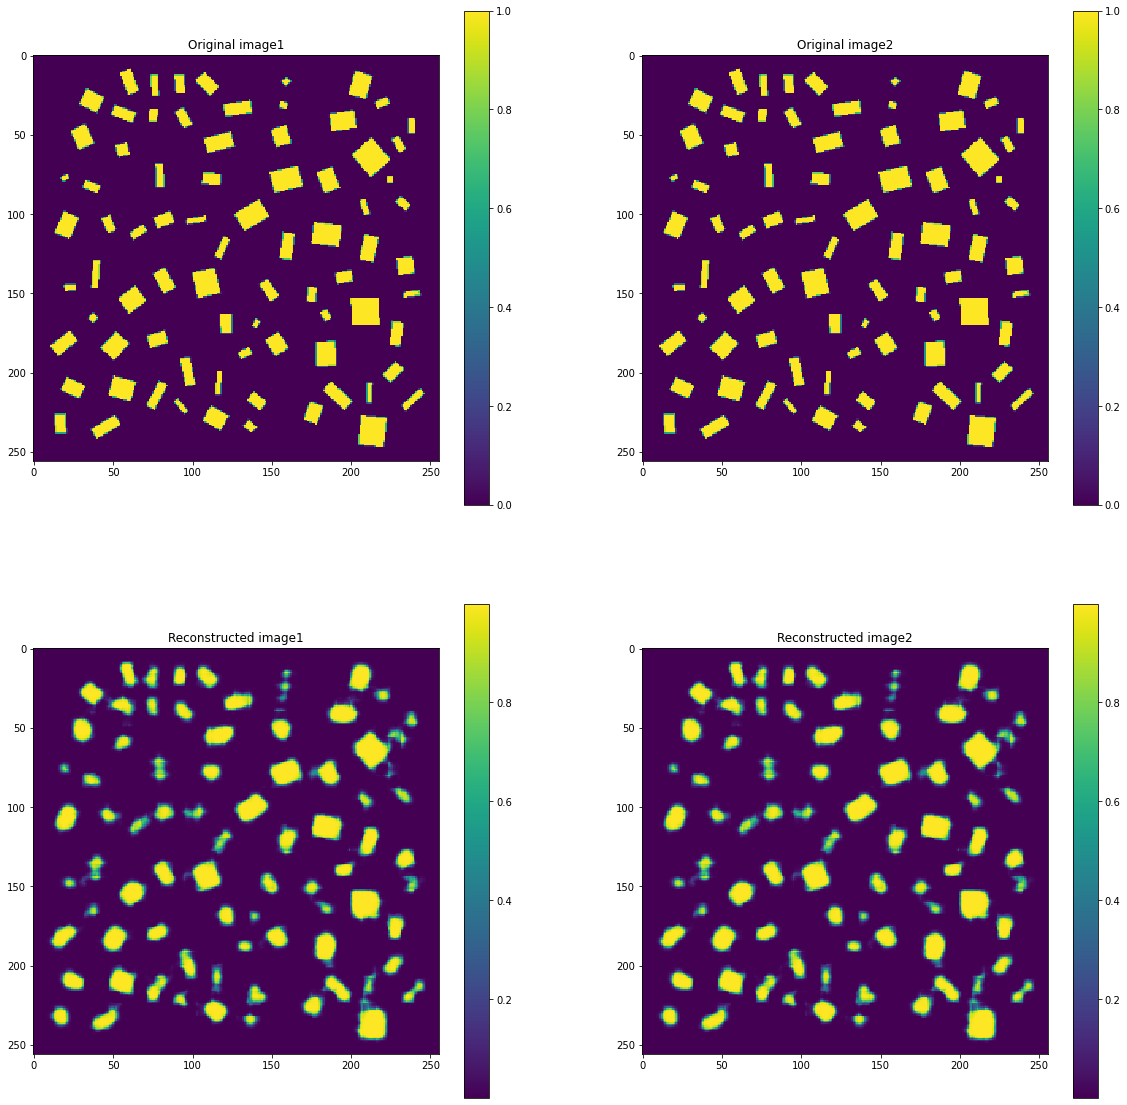

In [145]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued[101:102]
print(dataP.shape)

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, 256, 256))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

(1, 256, 256)
latent space shape torch.Size([1, 1, 32, 32])
(1, 1, 256, 256)


<Figure size 432x288 with 0 Axes>

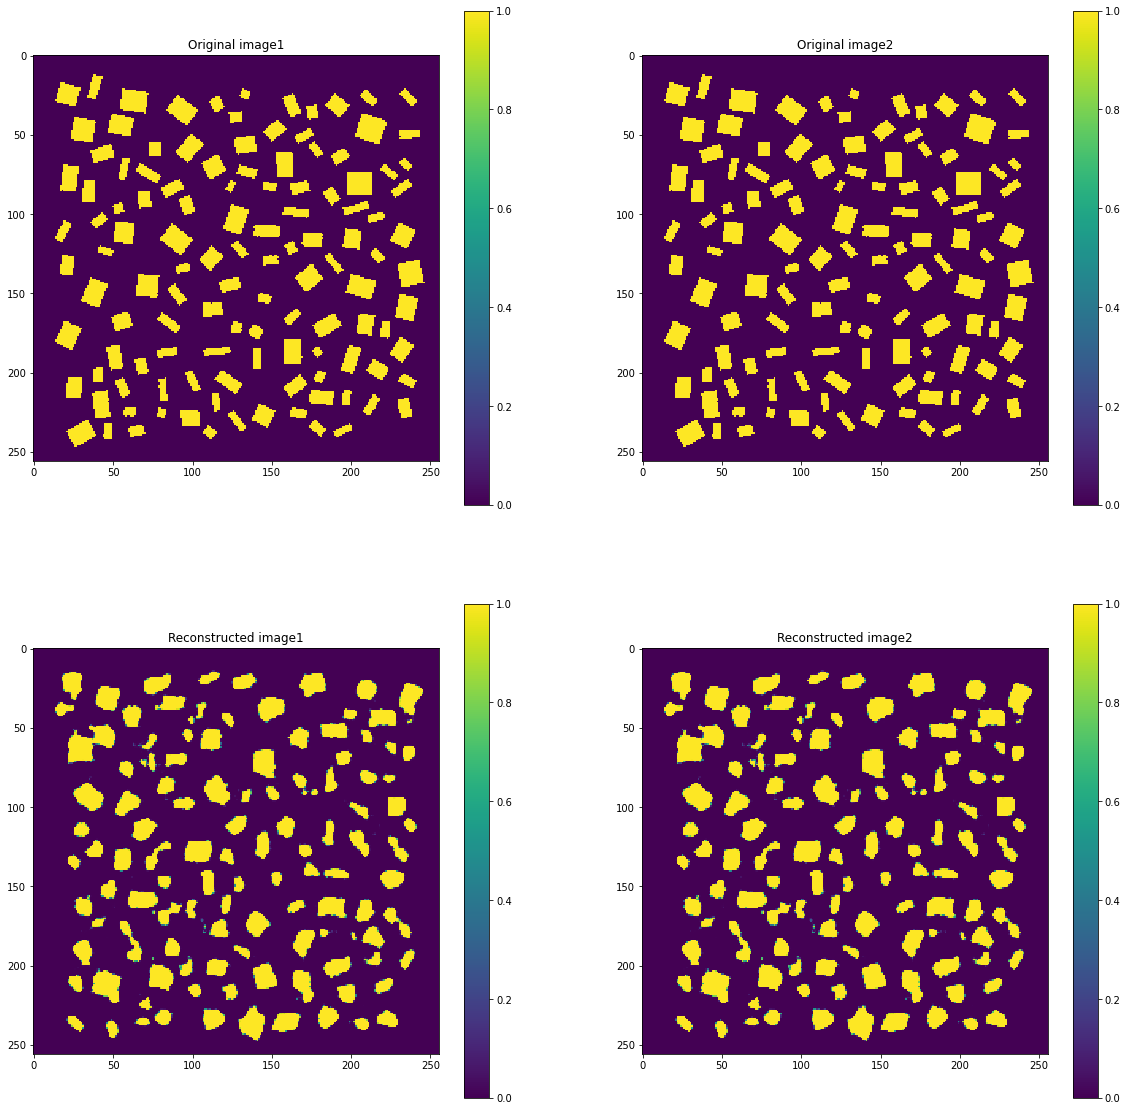

In [89]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued
print(dataP.shape)

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 3), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 3), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 1).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, 256, 256))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

In [60]:
dataP = concatenated_data_revalued
size_start = 0
size_end = 256

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 256, 256)
torch.Size([1, 1, 256, 256])
Latent space shape: torch.Size([1, 1, 32, 32])
(1, 1, 32, 32)


In [61]:
datasetFolder = 'Flow_Data'
xysize = 256

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_13232_tanhlatent.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_13232_tanhlatent.npy


### 9*9 domain

In [73]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

concatenated_data_384 = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/FpB_Interpolated_VelocityAbsorption_384_384.npy')

print(concatenated_data_384.shape)

(2, 384, 384)


In [74]:
concatenated_data_revalued_384 = concatenated_data_384.copy()
concatenated_data_revalued_384[concatenated_data_384 > 1500] = 1
concatenated_data_revalued_384[concatenated_data_384 <= 1500] = 0

concatenated_data_revalued_384 = concatenated_data_revalued_384[0,:,:].reshape(1,xysize,xysize)

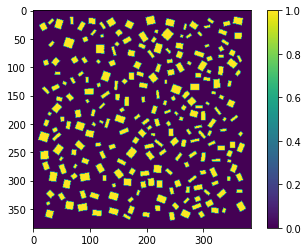

In [75]:
plt.imshow(concatenated_data_revalued_384[0,:,:])
plt.colorbar()

(1, 384, 384)
latent space shape torch.Size([1, 1, 48, 48])
(1, 1, 384, 384)


<Figure size 432x288 with 0 Axes>

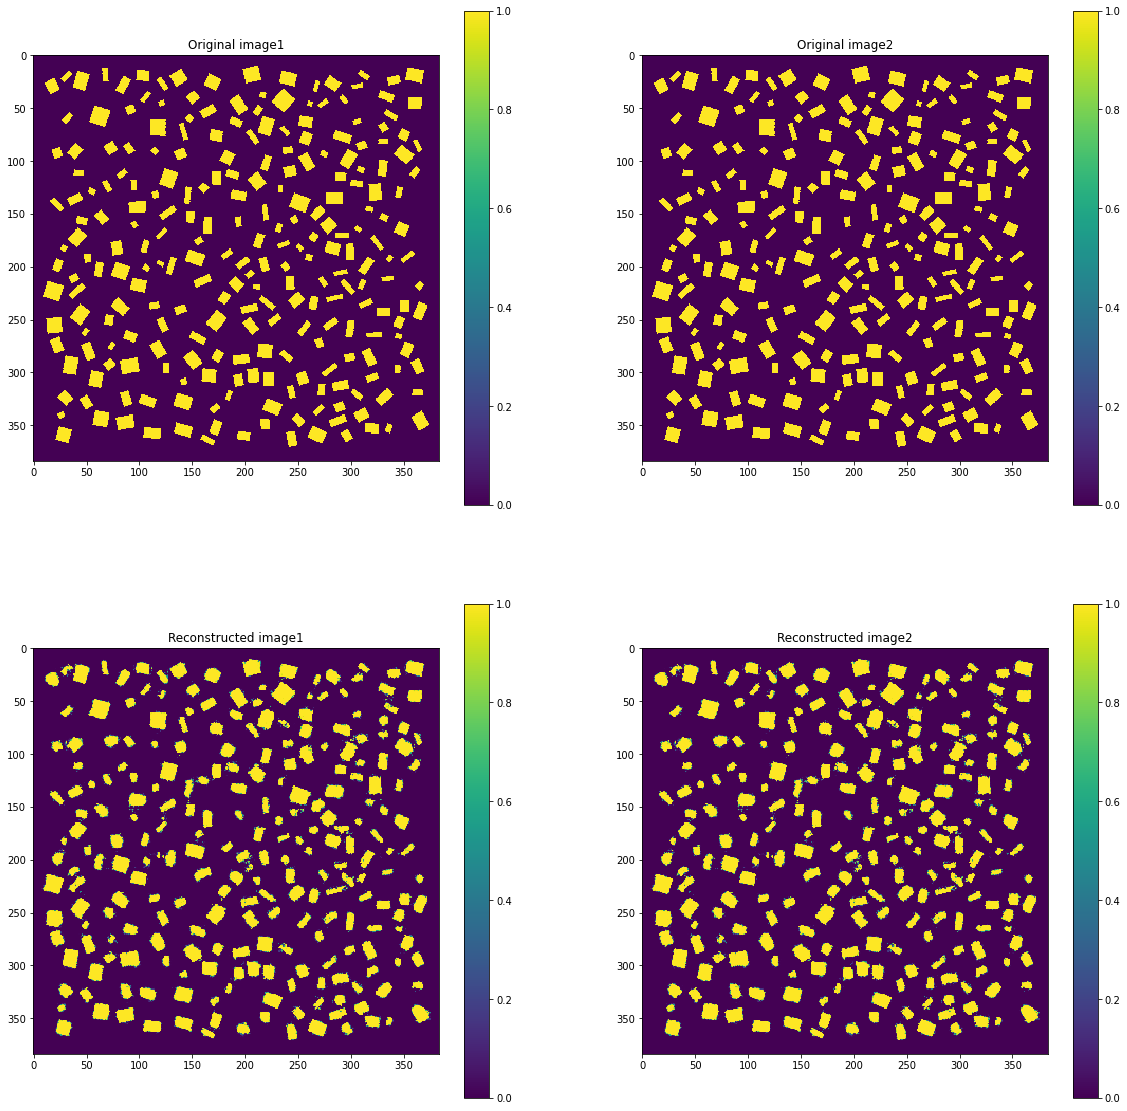

64.0


In [66]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued_384
print(dataP.shape)

size_start = 0
size_end = xysize

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, xysize, xysize))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, xysize, xysize))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

print((dataP.shape[-1]*dataP.shape[-1])/(latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3]))

In [67]:
dataP = concatenated_data_revalued_384
size_start = 0
size_end = xysize

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 384, 384)
torch.Size([1, 1, 384, 384])
Latent space shape: torch.Size([1, 1, 48, 48])
(1, 1, 48, 48)


In [83]:
384*384/(2*96*96)

8.0

In [68]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_14848_tanhlatent.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_384_384_14848_tanhlatent.npy
